<a href="https://colab.research.google.com/github/Konerusudhir/kaggle_datasets/blob/master/nlp/disaster/Disaster_prediction_using_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
# !pip uninstall -y tensorflow
# !pip uninstall -y tf-nightly-gpu
# !pip install tensorflow-gpu

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence,text
from tensorflow.python.keras import models, initializers, regularizers
from tensorflow.python.keras.layers import  InputLayer, BatchNormalization,Dense, Dropout, Embedding, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers

import tensorflow_hub as hub

import os
import random
import argparse
import time
import unicodedata
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, auc, classification_report, confusion_matrix, roc_curve, precision_recall_curve, f1_score

!pip install contractions
!pip install beautifulsoup4

import contractions
from bs4 import BeautifulSoup



In [0]:
# For finding Tensorflow version

print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Is GPU available:     " + str(tf.test.is_gpu_available()))
print("GPU Name:  " + tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

TF version:  2.0.0
Hub version:  0.7.0
Is GPU available:     True
GPU Name:  /device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13782061350148272939
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3030501206724426737
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17748052595114363770
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11931529481881581159
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Data

## Load Data

In [0]:
def split_training_and_validation_sets_with_shuffle(texts, labels, validation_split):
    """Splits the texts and labels into training and validation sets.
    # Arguments
        texts: list, text data.
        labels: list, label data.
        validation_split: float, percentage of data to use for validation.
    # Returns
        A tuple of training and validation data.
    """
    num_training_samples = int((1 - validation_split) * len(texts))
    X_train,X_test,y_train,y_test=train_test_split(
        texts,
        labels,
        test_size=0.20, 
        random_state = 777, 
        shuffle = True
    )
    print('Shape of Train',X_train.shape)
    print("Shape of Validation ",X_test.shape)

    return ((X_train, y_train),
            (X_test, y_test))

def load_disaster_dataset(validation_split=0.2,
                          seed=777):
    """Loads the tweet weather topic classification dataset.
    # Arguments
        data_path: string, path to the data directory.
        validation_split: float, percentage of data to use for validation.
        seed: int, seed for randomizer.
    # Returns
        A tuple of training and validation data.
        Number of training samples: 62356
        Number of test samples: 15590
        Number of topics: 15
    # References
        https://www.kaggle.com/c/crowdflower-weather-twitter/data
        Download from:
        https://www.kaggle.com/c/3586/download/train.csv
    """

    train = pd.read_csv("https://raw.githubusercontent.com/Konerusudhir/kaggle_datasets/master/nlp/disaster/train.csv", error_bad_lines=False)
    # test =  pd.read_csv("https://raw.githubusercontent.com/Konerusudhir/kaggle_datasets/master/nlp/disaster/test.csv", error_bad_lines=False)
    # submission = pd.read_csv("https://raw.githubusercontent.com/Konerusudhir/kaggle_datasets/master/nlp/disaster/sample_submission.csv", error_bad_lines=False)


    # columns = [1] + [i for i in range(13, 28)]  # 1 - text, 13-28 - topics.
    # data = _load_and_shuffle_data(data_path, 'train.csv', columns, seed)

    # # Get tweet text and the max confidence score for the weather types.
    # texts = list(data['tweet'])
    # weather_data = data.iloc[:, 1:]

    # labels = []
    # for i in range(len(texts)):
    #     # Pick topic with the max confidence score.
    #     labels.append(np.argmax(list(weather_data.iloc[i, :].values)))


    text = train.text
    labels = train.target
    
    return split_training_and_validation_sets_with_shuffle(
        text, labels, validation_split)

## Explore Data

In [0]:
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

## Clean Data

In [0]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)
    # lower case
    document = document.lower()
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    document = remove_accented_chars(document)
    # expand contractions    
    document = expand_contractions(document)  
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document

def clean_data(data):
    ((X_train, y_train), (X_test, y_test)) = data 
    pre_process_corpus = np.vectorize(pre_process_document)
    cleaned_train_text = pre_process_corpus(X_train)
    cleaned_test_text = pre_process_corpus(X_test)
    return ((cleaned_train_text, y_train), (cleaned_test_text, y_test))




# Build All Models

In [0]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.
    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model


def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.
    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.
    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model


def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.
    # Arguments
        num_classes: int, number of classes.
    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

## Smaller SepCNN Model

In [0]:
def sepcnn_model_smaller(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.
    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.
    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

## USE Model 

In [0]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
use_embedding_layer = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')
with tf.device('/gpu:0'):
    def build_use_model(train_use_layer=False):
        model = Sequential()
        model.add(InputLayer(input_shape=[], dtype=tf.string))     
        use_embedding_layer.trainable = train_use_layer 
        model.add(use_embedding_layer)
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
        model.summary()        

        return model

# Vectorize Data

In [0]:
# Vectorization parameters

# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as ngram vectors.
    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.
    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.
    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train)
    x_val = selector.transform(x_val)

    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    return x_train, x_val


def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.
    1 text = 1 sequence vector with fixed length.
    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.
    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

# Metrics

In [0]:
class CustomMetrics(tf.keras.callbacks.Callback):

    # parameterized constructor 
    def __init__(self,  val_texts, val_labels, model_name): 
        self.val_texts = tf.convert_to_tensor(val_texts, dtype=tf.string)
        self.val_labels = tf.convert_to_tensor(val_labels, dtype=tf.bool)
        self.model_name = model_name
        self.max_f1_score = 0.0

    def on_train_begin(self, logs={}):       
        self.f1s = []

    def on_epoch_end(self, epoch, logs={}):       
        if(epoch%5 == 0):
            score = np.asarray(self.model.predict(self.val_texts))
            predict = np.round(score)

            # self.accuracy.append(sklm.accuracy_score(y_test, predict))
            # self.precision.append(sklm.precision_score(y_test, predict))
            # self.recall.append(sklm.recall_score(y_test, predict))
            current_fl_score = f1_score(self.val_labels, predict)
            if(current_fl_score - self.max_f1_score > 0.0001): 
                # self.f1s.append(fl_score)
                logs["val_fl_score"] = current_fl_score
                print(" - val_f1_score: ", str(current_fl_score))
                self.model.save_weights(self.model_name)
                self.max_f1_score = current_fl_score

        return

# Train Definitions

## Train N Gram Model Definition

In [0]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('imdb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]


## Train Sequence Model Definition

In [0]:
TOP_K = 20000

def train_sequence_model(data,
                         learning_rate=1e-3,
                         epochs=1000,
                         batch_size=128,
                         blocks=2,
                         filters=64,
                         dropout_rate=0.2,
                         embedding_dim=200,
                         kernel_size=3,
                         pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Model Summary
    model.summary()
    
    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('rotten_tomatoes_sepcnn_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]




## Load Embeddings

In [0]:
def get_embedding_matrix(word_index, embedding_data_dir, embedding_dim):
    """Gets embedding matrix from the embedding index data.
    # Arguments
        word_index: dict, word to index map that was generated from the data.
        embedding_data_dir: string, path to the pre-training embeddings.
        embedding_dim: int, dimension of the embedding vectors.
    # Returns
        dict, word vectors for words in word_index from pre-trained embedding.
    # References:
        https://nlp.stanford.edu/projects/glove/
        Download and uncompress archive from:
        http://nlp.stanford.edu/data/glove.6B.zip
    """

    # Read the pre-trained embedding file and get word to word vector mappings.
    embedding_matrix_all = {}

    # We are using 200d GloVe embeddings.
    fname = os.path.join(embedding_data_dir, 'glove.twitter.27B.25d.txt')
    with open(fname) as f:
        for line in f:  # Every line contains word followed by the vector value
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix_all[word] = coefs

    # Prepare embedding matrix with just the words in our word_index dictionary
    num_words = min(len(word_index) + 1, TOP_K)
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i >= TOP_K:
            continue
        embedding_vector = embedding_matrix_all.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


## Train Fine Tuned Sequence Model

In [0]:
TOP_K = 20000

def train_fine_tuned_sequence_model(data,
                                    embedding_data_dir,
                                    learning_rate=1e-3,
                                    epochs=1000,
                                    batch_size=128,
                                    blocks=2,
                                    filters=64,
                                    dropout_rate=0.2,
                                    embedding_dim=25,
                                    kernel_size=3,
                                    pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        embedding_data_dir: string, path to the pre-training embeddings.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    embedding_matrix = get_embedding_matrix(
        word_index, embedding_data_dir, embedding_dim)

    # Create model instance. First time we will train rest of network while
    # keeping embedding layer weights frozen. So, we set
    # is_embedding_trainable as False.
    model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features,
                                     use_pretrained_embedding=True,
                                     is_embedding_trainable=False,
                                     embedding_matrix=embedding_matrix)

    # Model Summary
    model.summary()

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    model.fit(x_train,
              train_labels,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=(x_val, val_labels),
              verbose=2,  # Logs once per epoch.
              batch_size=batch_size)

    # Save the model.
    model.save_weights('sequence_model_with_pre_trained_embedding.h5')

    # Create another model instance. This time we will unfreeze the embedding
    # layer and let it fine-tune to the given dataset.
    model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features,
                                     use_pretrained_embedding=True,
                                     is_embedding_trainable=True,
                                     embedding_matrix=embedding_matrix)

    # Compile model with learning parameters.
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Load the weights that we had saved into this new model.
    model.load_weights('sequence_model_with_pre_trained_embedding.h5')

    # Train and validate model.
    history = model.fit(x_train,
                        train_labels,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=(x_val, val_labels),
                        verbose=2,  # Logs once per epoch.
                        batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('tweet_weather_sepcnn_fine_tuned_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]


## Train Smaller Fine Tune Sequence Model

In [0]:
TOP_K = 20000

def train_smaller_fine_tuned_sequence_model(data,
                                    embedding_data_dir,
                                    learning_rate=1e-3,
                                    epochs=1000,
                                    batch_size=128,
                                    blocks=2,
                                    filters=64,
                                    dropout_rate=0.2,
                                    embedding_dim=25,
                                    kernel_size=3,
                                    pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        embedding_data_dir: string, path to the pre-training embeddings.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    embedding_matrix = get_embedding_matrix(
        word_index, embedding_data_dir, embedding_dim)

    # Create model instance. First time we will train rest of network while
    # keeping embedding layer weights frozen. So, we set
    # is_embedding_trainable as False.
    model = sepcnn_model_smaller(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features,
                                     use_pretrained_embedding=True,
                                     is_embedding_trainable=False,
                                     embedding_matrix=embedding_matrix)

    # Model Summary
    model.summary()

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

    metrics = [
        'accuracy', 
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    model.fit(x_train,
              train_labels,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=(x_val, val_labels),
              verbose=2,  # Logs once per epoch.
              batch_size=batch_size)

    # Save the model.
    model.save_weights('smaller_sequence_model_with_pre_trained_embedding.h5')

    # Create another model instance. This time we will unfreeze the embedding
    # layer and let it fine-tune to the given dataset.
    model = sepcnn_model_smaller(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features,
                                     use_pretrained_embedding=True,
                                     is_embedding_trainable=True,
                                     embedding_matrix=embedding_matrix)

    # Compile model with learning parameters.
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Load the weights that we had saved into this new model.
    model.load_weights('smaller_sequence_model_with_pre_trained_embedding.h5')

    # Train and validate model.
    history = model.fit(x_train,
                        train_labels,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=(x_val, val_labels),
                        verbose=2,  # Logs once per epoch.
                        batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('smaller_sequence_model_with_pre_trained_embedding.h5')
    return history['val_acc'][-1], history['val_loss'][-1]




## Train USE Model Definition

In [0]:
def train_use_model(data,
                    batch_size=64,
                    epochs=20):

    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    train_texts = tf.convert_to_tensor(train_texts.values, dtype=tf.string)
    train_labels = tf.convert_to_tensor(train_labels.values, dtype=tf.bool)
    val_texts = tf.convert_to_tensor(val_texts.values, dtype=tf.string)
    val_labels = tf.convert_to_tensor(val_labels.values, dtype=tf.bool)

    model = build_use_model(train_use_layer = False)

    optimizer = Adam(lr = 0.0001)
    metrics = [
        'accuracy', 
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]
    
    model.compile(optimizer, loss='binary_crossentropy', metrics=metrics)  

    checkpoint = ModelCheckpoint(
        'model_use_low_val_loss.h5', 
        monitor='val_loss', 
        mode='min', 
        modelsave_best_only=True)
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        min_delta=0.0001, 
        patience=10)

    callbacks = [
                 CustomMetrics(
                     val_texts, 
                     val_labels, 
                     "model_use_high_f1_score.h5"
                     ), 
                 early_stopping, 
                 checkpoint]

    # Train
    history = model.fit(train_texts,
                        train_labels,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=(val_texts, val_labels),
                        verbose=1,  
                        batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_accuracy'][-1], loss=history['val_loss'][-1]))

    #
    #  Fine Tuning the model
    #
    model = build_use_model(train_use_layer = True)
    optimizer = Adam(lr = 0.00001)
    model.compile(optimizer, loss='binary_crossentropy', metrics=metrics)  

    model.load_weights("model_use_low_val_loss.h5")
    checkpoint = ModelCheckpoint(
        'model_use_fine_tuned_low_val_loss.h5', 
        monitor='val_loss', 
        mode='min', 
        modelsave_best_only=True)

    callbacks = [CustomMetrics(
                     val_texts, 
                     val_labels, 
                     "model_use_fine_tuned_high_f1_score.h5"
                     ), 
                 early_stopping, 
                 checkpoint]
    history = model.fit(train_texts,
                    train_labels,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=(val_texts, val_labels),
                    verbose=1,  
                    batch_size=batch_size)
    
    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_accuracy'][-1], loss=history['val_loss'][-1]))
    
    return model
    

# Plot Data

In [0]:
def plot_data(data):
    (train_texts, train_labels), (val_texts, val_labels) = data
    plot_frequency_distribution_of_ngrams(train_texts)
    plot_sample_length_distribution(train_texts)
    plot_class_distribution(train_labels)

# Invoke Training

## Load Data

In [0]:
data = load_disaster_dataset()

Shape of Train (6090,)
Shape of Validation  (1523,)


## Invoke N Gram Training

In [0]:
# train_ngram_model(data, epochs = 20)

## Invoke Sequence Model Training

In [0]:
# train_sequence_model(data, epochs = 20)

## Invoke FIne Tuned Sequence Model Training

In [0]:
# plot_data(data)
# train_fine_tuned_sequence_model(cleaned_data, "/content", epochs = 20)


## Clean Data

In [0]:
# cleaned_data = clean_data(data)

## Cleaned Data Fine Tuning

In [0]:
# plot_data(cleaned_data)
# train_fine_tuned_sequence_model(cleaned_data, "/content", epochs = 20)

## Invoke Smaller Fine Tuned Sequence Model

In [0]:
# cleaned_data = clean_data(data)
# plot_data(cleaned_data)
# train_smaller_fine_tuned_sequence_model(data, "/content", epochs = 20)

## Smaller Fine tuning on cleaned Data

In [0]:
# cleaned_data = clean_data(data)
# plot_data(cleaned_data)
# train_smaller_fine_tuned_sequence_model(data, "/content", epochs = 20)

## USE Model Training invocation

In [0]:
# ((x_train, y_train), (_,_)) = data
# print(y_train.values)
# x_train_c = tf.convert_to_tensor(x_train, dtype=tf.string)
# print(x_train_c)
# build_use_model(True)
model = train_use_model(data, epochs=1000)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   {'outputs': (None, 512)}  147354880 
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)              

6090/6090 [==============================] - 147s 24ms/sample - loss: 0.4496 - accuracy: 0.8980 - recall_3: 0.8596 - precision_3: 0.8972 - val_loss: 0.6656 - val_accuracy: 0.8155 - val_recall_3: 0.7377 - val_precision_3: 0.8250
Epoch 2/1000
6090/6090 [==============================] - 45s 7ms/sample - loss: 0.4405 - accuracy: 0.9013 - recall_3: 0.8523 - precision_3: 0.9108 - val_loss: 0.6652 - val_accuracy: 0.8148 - val_recall_3: 0.7377 - val_precision_3: 0.8236
Epoch 3/1000
6090/6090 [==============================] - 46s 8ms/sample - loss: 0.4315 - accuracy: 0.9059 - recall_3: 0.8581 - precision_3: 0.9162 - val_loss: 0.6670 - val_accuracy: 0.8162 - val_recall_3: 0.7332 - val_precision_3: 0.8297
Epoch 4/1000
6090/6090 [==============================] - 44s 7ms/sample - loss: 0.4225 - accuracy: 0.9107 - recall_3: 0.8677 - precision_3: 0.9186 - val_loss: 0.6681 - val_accuracy: 0.8175 - val_recall_3: 0.7347 - val_precision_3: 0.8314
Epoch 5/1000
6090/6090 [==============================]

# Inference

              precision    recall  f1-score   support

        Real       0.82      0.88      0.85       852
    Not Real       0.83      0.75      0.79       671

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.82      1523
weighted avg       0.82      0.82      0.82      1523

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


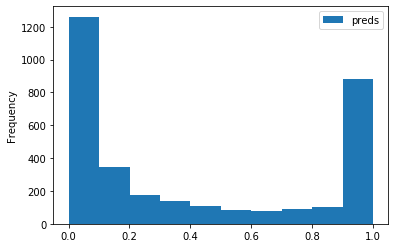

In [0]:

((x_train, y_train), (X_test,y_test)) = data
train_texts = tf.convert_to_tensor(x_train.values, dtype=tf.string)
train_labels = tf.convert_to_tensor(y_train.values, dtype=tf.bool)
val_texts = tf.convert_to_tensor(X_test.values, dtype=tf.string)
val_labels = tf.convert_to_tensor(y_test.values, dtype=tf.bool)


model.load_weights('model_use_fine_tuned_high_f1_score.h5')
predictions = model.predict(val_texts)

def findClasses(predictions):
    true_preds = []
    a=1
    b=0

    for i in predictions:
        if i >= 0.5:
            true_preds.append(a)
        else:
            true_preds.append(b)
    return true_preds

classes = findClasses(predictions)
print(classification_report(val_labels, classes, target_names=["Real", "Not Real"]))


test_data =  pd.read_csv("https://raw.githubusercontent.com/Konerusudhir/kaggle_datasets/master/nlp/disaster/test.csv", error_bad_lines=False)

test_pred = model.predict(test_data.text.values)
pred =  pd.DataFrame(test_pred, columns=['preds'])
pred.plot.hist()


submission = pd.read_csv("https://raw.githubusercontent.com/Konerusudhir/kaggle_datasets/master/nlp/disaster/sample_submission.csv", error_bad_lines=False)
# This for loop its for round predictions
submission['target'] = findClasses(test_pred)
print(submission.head())
submission.to_csv('submission.csv', index=False)